# Data Prepare

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Download

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download."""
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        last_percent_reported = percent
        
def maybe_download(filename, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')
extra_filename = maybe_download('extra.tar.gz')

## Decompress

In [5]:
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = root
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.
extra already present - Skipping extraction of extra.tar.gz.


## Process mat file

In [23]:
import h5py

class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    # getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    # getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    # getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            item['boxes'] = figures
            result.append(item)
        return result
    
dsf = DigitStructFile('./train/digitStruct.mat')
train_data = dsf.getAllDigitStructure_ByDigit()
print('Train completed')

dsf = DigitStructFile('./test/digitStruct.mat')
test_data = dsf.getAllDigitStructure_ByDigit()
print('Test completed')

dsf = DigitStructFile('./extra/digitStruct.mat')
extra_data = dsf.getAllDigitStructure_ByDigit()
print('Extra completed')

Train completed
Test completed
Extra completed


## Data exploration

In [24]:
print('Training size:', len(train_data))
print('Testing size:',len(test_data))
print('Extra images:',len(extra_data))

Training size: 33402
Testing size: 13068
Extra images: 202353


In [16]:
from PIL import Image
import pandas as pd

def size_and_numdigits(data, folder):
    numdigits = [0]*6
    imsize = np.ndarray([len(data),2])
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        imsize[i, :] = im.size[:]
    
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        if num_digit>5:
            numdigits[5] += 1
        else:
            numdigits[num_digit-1] += 1
    return imsize, numdigits

train_imsize, train_numdigits = size_and_numdigits(train_data, 'train')
print('Train completed')
test_imsize, test_numdigits = size_and_numdigits(test_data, 'test')
print('Test completed')
extra_imsize, extra_numdigits = size_and_numdigits(extra_data, 'extra')
print('Extra completed')

Train completed
Test completed
Extra completed


In [17]:
d = {'Max. Height' : pd.Series([np.amax(train_imsize[:,1]), np.amax(test_imsize[:,1]), np.amax(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Min. Height' : pd.Series([np.amin(train_imsize[:,1]), np.amin(test_imsize[:,1]), np.amin(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Avg. Height' : pd.Series([np.mean(train_imsize[:,1]), np.mean(test_imsize[:,1]), np.mean(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Max. Width' : pd.Series([np.amax(train_imsize[:,0]), np.amax(test_imsize[:,0]), np.amax(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra']),
     'Min. Width' : pd.Series([np.amin(train_imsize[:,0]), np.amin(test_imsize[:,0]), np.amin(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra']),
     'Avg. Width' : pd.Series([np.mean(train_imsize[:,0]), np.mean(test_imsize[:,0]), np.mean(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra'])}
df = pd.DataFrame(d)
display(df)

,Avg. Height,Avg. Width,Max. Height,Max. Width,Min. Height,Min. Width
Training,57.213011,128.284983,501,876,12,25
Testing,71.566498,172.583486,516,1083,13,31
Extra,60.800151,100.389250,415,668,13,22


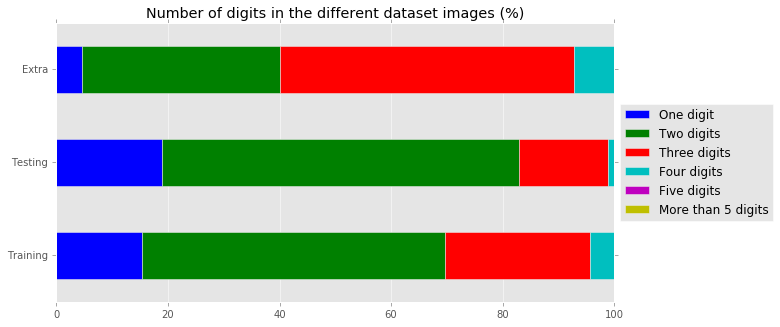

In [18]:
import matplotlib
matplotlib.style.use('ggplot')

# Computing how much % each group represents
train_numdigits_per = np.array([0, 0, 0, 0, 0, 0], dtype=float)
test_numdigits_per = np.array([0, 0, 0, 0, 0, 0], dtype=float)
extra_numdigits_per = np.array([0, 0, 0, 0, 0, 0], dtype=float)

np.true_divide(np.multiply(train_numdigits,100),np.sum(train_numdigits), train_numdigits_per)
np.true_divide(np.multiply(test_numdigits,100),np.sum(test_numdigits), test_numdigits_per)
np.true_divide(np.multiply(extra_numdigits,100),np.sum(extra_numdigits), extra_numdigits_per)

# Now add the legend with some customizations.
df2 = pd.DataFrame(np.vstack((train_numdigits_per, test_numdigits_per, extra_numdigits_per)), columns=['One digit', 'Two digits', 'Three digits', 'Four digits', 'Five digits', 'More than 5 digits'], index=['Training', 'Testing', 'Extra'])

f = plt.figure(1, figsize = (10,5))
plt.title('Number of digits in the different dataset images (%)', color='black')
df2.plot.barh(stacked=True, ax=f.gca())
axes = plt.gca()
axes.set_xlim([0,100])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Preprocess

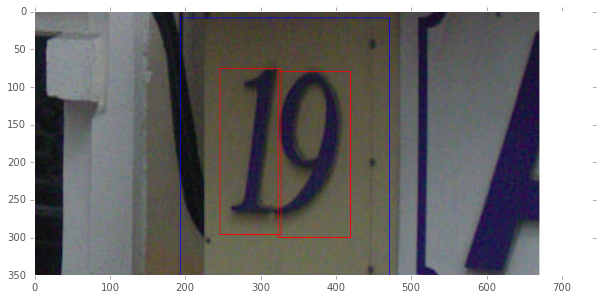

In [19]:
# Taking one picture as an example
sample_image = 0
from PIL import Image, ImageDraw
filename = train_data[sample_image]['filename']
fullname = os.path.join(train_folders, filename)
im = Image.open(fullname)

draw = ImageDraw.Draw(im)

boxes = train_data[sample_image]['boxes']
top = np.ndarray([len(boxes)], dtype='float32')
left = np.ndarray([len(boxes)], dtype='float32')
height = np.ndarray([len(boxes)], dtype='float32')
width = np.ndarray([len(boxes)], dtype='float32')
for i in range(len(boxes)):
    # Plotting individual bounding boxes in red
    draw.rectangle([boxes[i]['left'], boxes[i]['top'], boxes[i]['left']+boxes[i]['width'], boxes[i]['top']+boxes[i]['height']], fill=None, outline=(255,0,0))
    top[i] = boxes[i]['top']
    left[i] = boxes[i]['left']
    height[i] = boxes[i]['height']
    width[i] = boxes[i]['width']

im_top = np.amin(top)
im_left = np.amin(left)
im_height = np.amax(top) + height[np.argmax(top)] - im_top
im_width = np.amax(left) + width[np.argmax(left)] - im_left

# Expanding by 30%
im_bottom = np.amin([np.ceil(im_top + 1.3 * im_height), im.size[1]])
im_right = np.amin([np.ceil(im_left + 1.3 * im_width), im.size[0]])
im_top = np.amax([np.floor(im_top - 0.3 * im_height), 0])
im_left = np.amax([np.floor(im_left - 0.3 * im_width), 0])

# Plotting expanded bounding box in blue
draw.rectangle([im_left, im_top, im_right, im_bottom], fill=None, outline=(0,0,255))

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(im)
plt.grid(False)

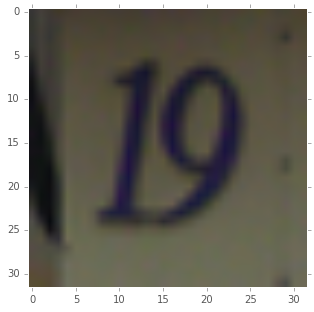

In [20]:
SIZE_CROP = 32
filename = train_data[sample_image]['filename']
fullname = os.path.join(train_folders, filename)
im = Image.open(fullname)
im = im.crop((int(im_left), int(im_top), int(im_right), int(im_bottom))).resize([SIZE_CROP,SIZE_CROP], Image.ANTIALIAS)
draw = ImageDraw.Draw(im)

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(im)
plt.grid(False)

## Generation

In [27]:
import PIL.Image as Image

SIZE_CROP = 32
def generate_dataset(data, folder):
    dataset = np.ndarray([len(data),SIZE_CROP,SIZE_CROP,3], dtype=np.int8)
    labels = np.ones([len(data),6], dtype=np.int8) * 10

    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        temp_label = [10] * 6
        temp_label[0] = num_digit
        
        # Get the individual bounding boxes
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5: 
                if boxes[j]['label'] == 10:
                    temp_label[j+1] = 0
                else:
                    temp_label[j+1] = boxes[j]['label']
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        # Get the bounding box surrounding all digits
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left

        # Expanding by 30%
        im_bottom = np.amin([np.ceil(im_top + 1.3 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.3 * im_width), im.size[0]])
        im_top = np.amax([np.floor(im_top - 0.3 * im_height), 0])
        im_left = np.amax([np.floor(im_left - 0.3 * im_width), 0])
        
        # Cropping the expanded bounding box
        im = im.crop((int(im_left), int(im_top), int(im_right), int(im_bottom))).resize([SIZE_CROP,SIZE_CROP], Image.ANTIALIAS)
        dataset[i,:,:,:] = im
        labels[i,:] = temp_label     

    return dataset, labels


train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

extra_dataset, extra_labels = generate_dataset(extra_data, extra_folders)
print(extra_dataset.shape, extra_labels.shape)

del train_data
del test_data
del extra_data

(33402, 32, 32, 3) (33402, 6)
(13068, 32, 32, 3) (13068, 6)
(202353, 32, 32, 3) (202353, 6)


## Shuffle

In [28]:
import random
random.seed()

# Percentage of Training/Extra data to use for validation
validation_prop = 0.1

n_digits = 5
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []

for i in np.arange(n_digits):
    idx = np.where(train_labels[:,0] == (i+1))[0]
    numel_samples = len(idx)
    valid_index.extend(idx[:int(np.floor(numel_samples*validation_prop))].tolist())
    train_index.extend(idx[int(np.floor(numel_samples*validation_prop)):].tolist())
    
    idx = np.where(extra_labels[:,0] == (i+1))[0]
    numel_samples = len(idx)
    valid_index2.extend(idx[:int(np.floor(numel_samples*validation_prop))].tolist())
    train_index2.extend(idx[int(np.floor(numel_samples*validation_prop)):].tolist())

# Shuffling the data
random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
train_dataset_t = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)

#del train_dataset, train_labels, valid_index, valid_index2, train_index, train_index2
print(train_dataset_t.shape, train_labels_t.shape)
print(valid_dataset.shape, valid_labels.shape)

(212184, 32, 32, 3) (212184, 6)
(23570, 32, 32, 3) (23570, 6)


## Binary file

In [30]:
# Training dataset
temp = np.reshape(train_dataset_t,(train_dataset_t.shape[0],train_dataset_t.shape[1]*train_dataset_t.shape[2]*train_dataset_t.shape[3]))
temp = np.concatenate((train_labels_t,temp), axis=1)

# Splitting the data into different files in order to gain some parallelism when loading samples
num_files = 3
number_per_file = temp.shape[0] // num_files
for i in range(num_files):
    if i==num_files-1:
        segment = temp[i*number_per_file:,:]
    else:
        segment = temp[i*number_per_file:(i+1)*number_per_file,:]
    
    filename = 'Train' + str(i+1) + '.bin'
    contents = segment.tobytes()
    open(filename, "wb").write(contents)

del temp

## Pickle file

In [31]:
pickle_file = './SVHN.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 112772077
